In [351]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

import jax
import jax.numpy as jnp
from jax import random, tree_util
jax.config.update("jax_enable_x64", True)

import jaxopt
from corner import corner

from jax.scipy.stats import norm, uniform

In [355]:
rstate = np.random.default_rng(56101)

In [356]:
# truth
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# generate mock data
N = 50
x = np.sort(10 * rstate.uniform(size=N))
yerr = 0.1 + 0.5 * rstate.uniform(size=N)
y_true = m_true * x + b_true
y = y_true + np.abs(f_true * y_true) * rstate.normal(size=N)
y += yerr * rstate.normal(size=N)

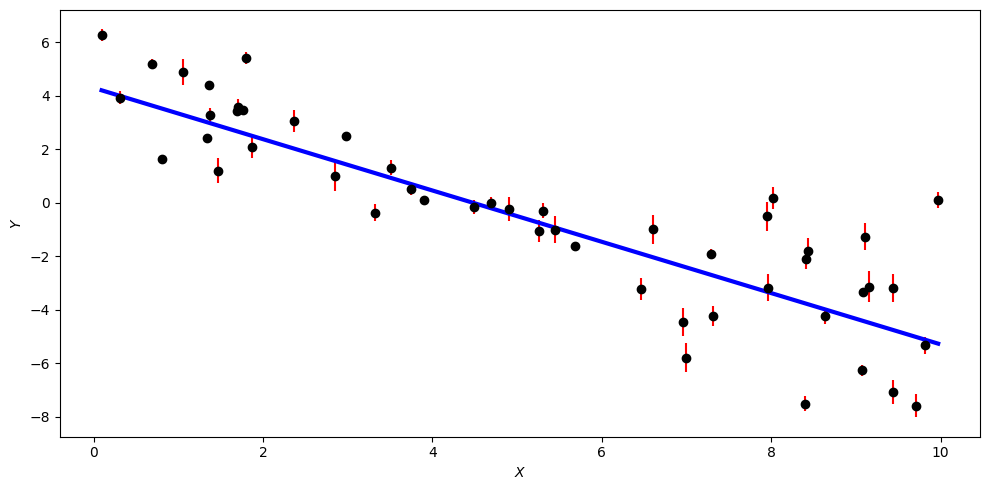

In [357]:
# plot results
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.tight_layout()

In [358]:
import dynesty

In [372]:

slope = Normal(0.0, 2.0)
# log-likelihood
@jax.jit
def log_likelihood(params):
    model = params["slope"] * x + params["intercept"]
    inv_var = 1.0 / (yerr**2 + model**2 * jnp.exp(2 * params["log_frac_sigma"]))
    
    return - 0.5 * (jnp.sum((y - model)**2 * inv_var - jnp.log(inv_var)))

# prior transform
@jax.jit
def prior_transform(uparams):
    params = {}
#     params["slope"] = 5.5 * uparams["slope"] - 5.
    params["slope"] = slope.inv_cdf(uparams["slope"])
    params["intercept"] = 10. * uparams["intercept"]
    params["log_frac_sigma"] = 11. * uparams["log_frac_sigma"] - 10.
    return params

@jax.grad
def gradient(uparams):
    params = prior_transform(uparams)
    return log_likelihood(params)

In [373]:
init_params = {
    "slope": 0.0,
    "intercept": 0.0,
    "log_frac_sigma": 0.0,
}

In [374]:
leaves, treedef = tree_util.tree_flatten(init_params)
ndim = len(leaves)

In [375]:
def log_likelihood_wrapper(x):
    params = tree_util.tree_unflatten(treedef, x)
    return log_likelihood(params)

def prior_transform_wrapper(u):
    params = tree_util.tree_unflatten(treedef, u)
    return tree_util.tree_leaves(prior_transform(params))

def gradient_wrapper(u):
    uparams = tree_util.tree_unflatten(treedef, u)
    return np.array(tree_util.tree_leaves(gradient(uparams)))

In [376]:
sampler = dynesty.NestedSampler(log_likelihood_wrapper, prior_transform_wrapper, ndim=ndim)
sampler.run_nested()

1540it [00:01, 510.75it/s, bound: 0 | nc: 24 | ncall: 9759 | eff(%): 15.780 | loglstar:   -inf < -144.149 <    inf | logz: -151.179 +/-  0.109 | dlogz: 105.587 >  0.509]    Traceback (most recent call last):
  File "/Users/ajl573/.pyenv/versions/thesis/lib/python3.9/site-packages/dynesty/dynesty.py", line 896, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/var/folders/zr/3f9t9zzs1tq27438cp0fqn19z0ds79/T/ipykernel_69030/1877504918.py", line 7, in prior_transform_wrapper
    return tree_util.tree_leaves(prior_transform(params))
KeyboardInterrupt
1570it [00:01, 852.71it/s, bound: 0 | nc: 14 | ncall: 10222 | eff(%): 15.359 | loglstar:   -inf < -142.215 <    inf | logz: -148.757 +/-  0.107 | dlogz: 103.061 >  0.509]


Exception while calling prior_transform function:
  params: [0.48695456 0.60012349 0.73944896]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [363]:
dsampler = dynesty.DynamicNestedSampler(log_likelihood_wrapper, prior_transform_wrapper, ndim=ndim,
                                bound='multi', sample='auto', rstate=rstate)
dsampler.run_nested()
dres = dsampler.results

1757it [00:03, 479.96it/s, batch: 0 | bound: 0 | nc: 22 | ncall: 17082 | eff(%):  9.993 | loglstar:   -inf < -128.482 <    inf | logz: -135.357 +/-  0.108 | dlogz: 90.014 >  0.010]   


KeyboardInterrupt: 

In [11]:
true_params = {
    "slope": m_true,
    "intercept": b_true,
    "log_frac_sigma": np.log(f_true),
}

param_labels = {
    "slope": r'$m$',
    "intercept": r'$b$',
    "log_frac_simga": r'$\ln f$',
}

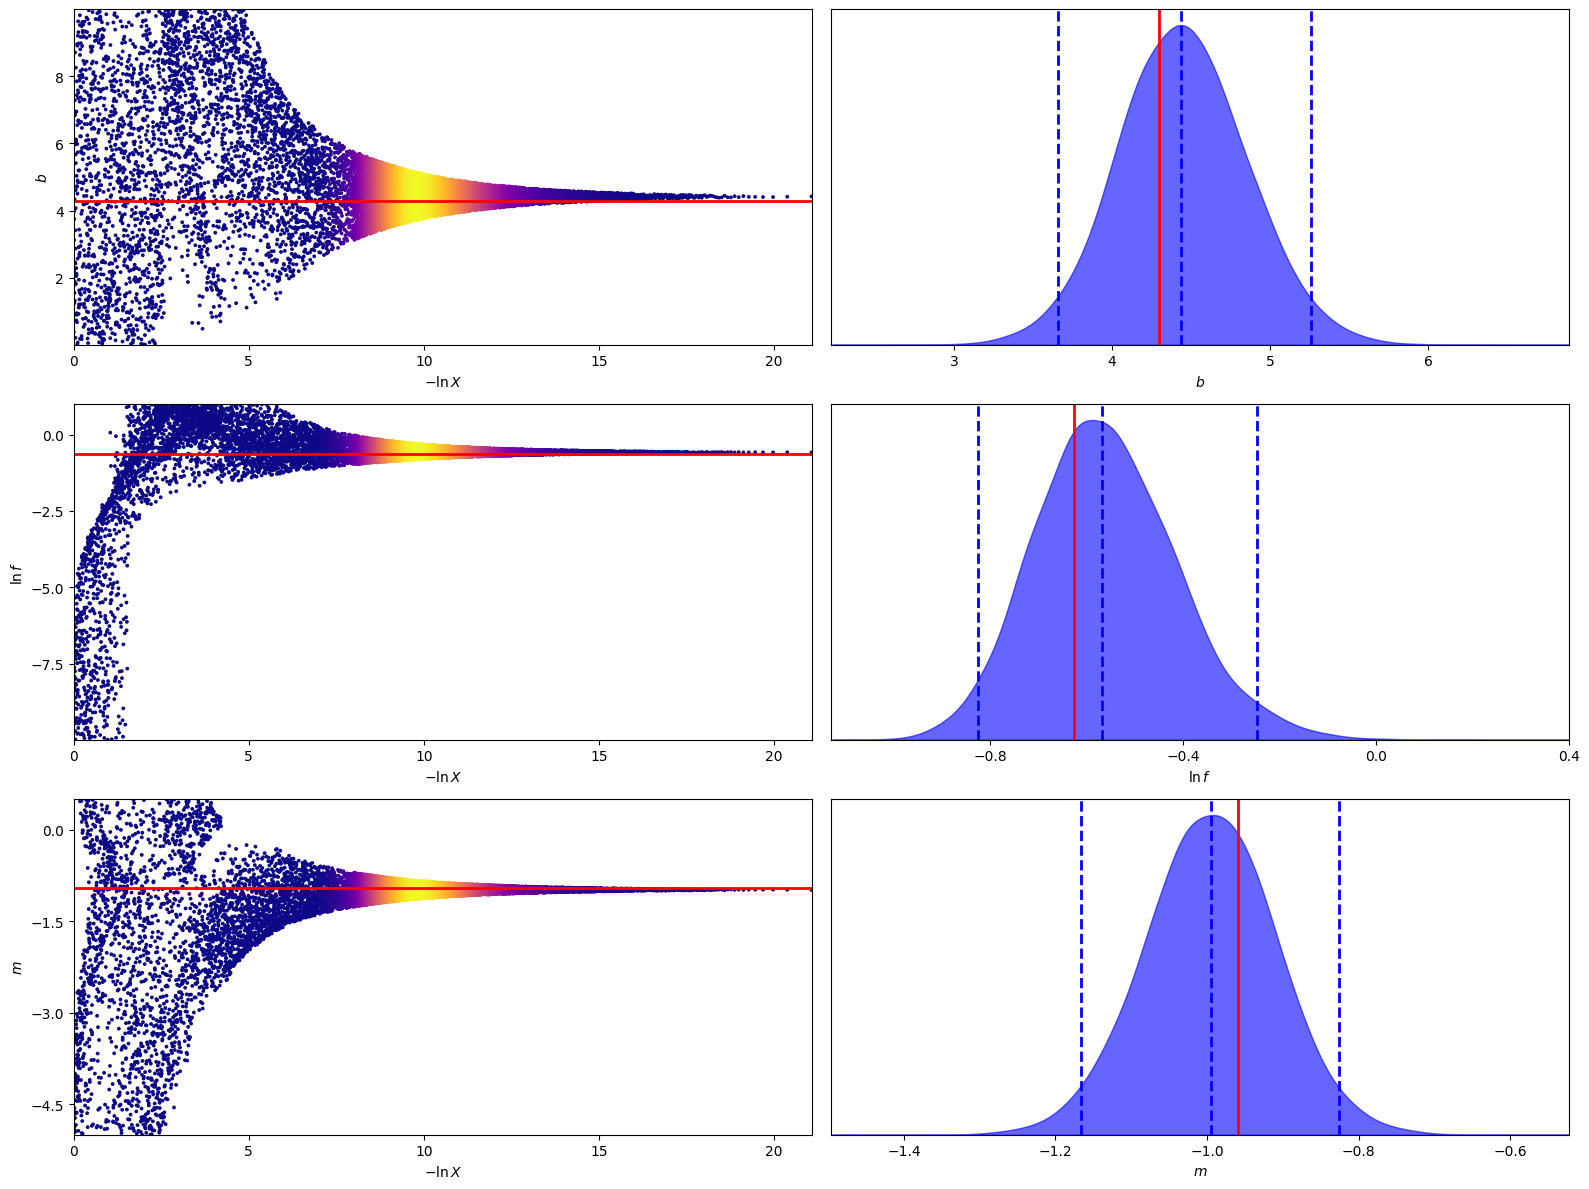

In [12]:
from dynesty import plotting as dyplot

labels = tree_util.tree_leaves(param_labels)
truths = tree_util.tree_leaves(true_params)
fig, axes = dyplot.traceplot(dres, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

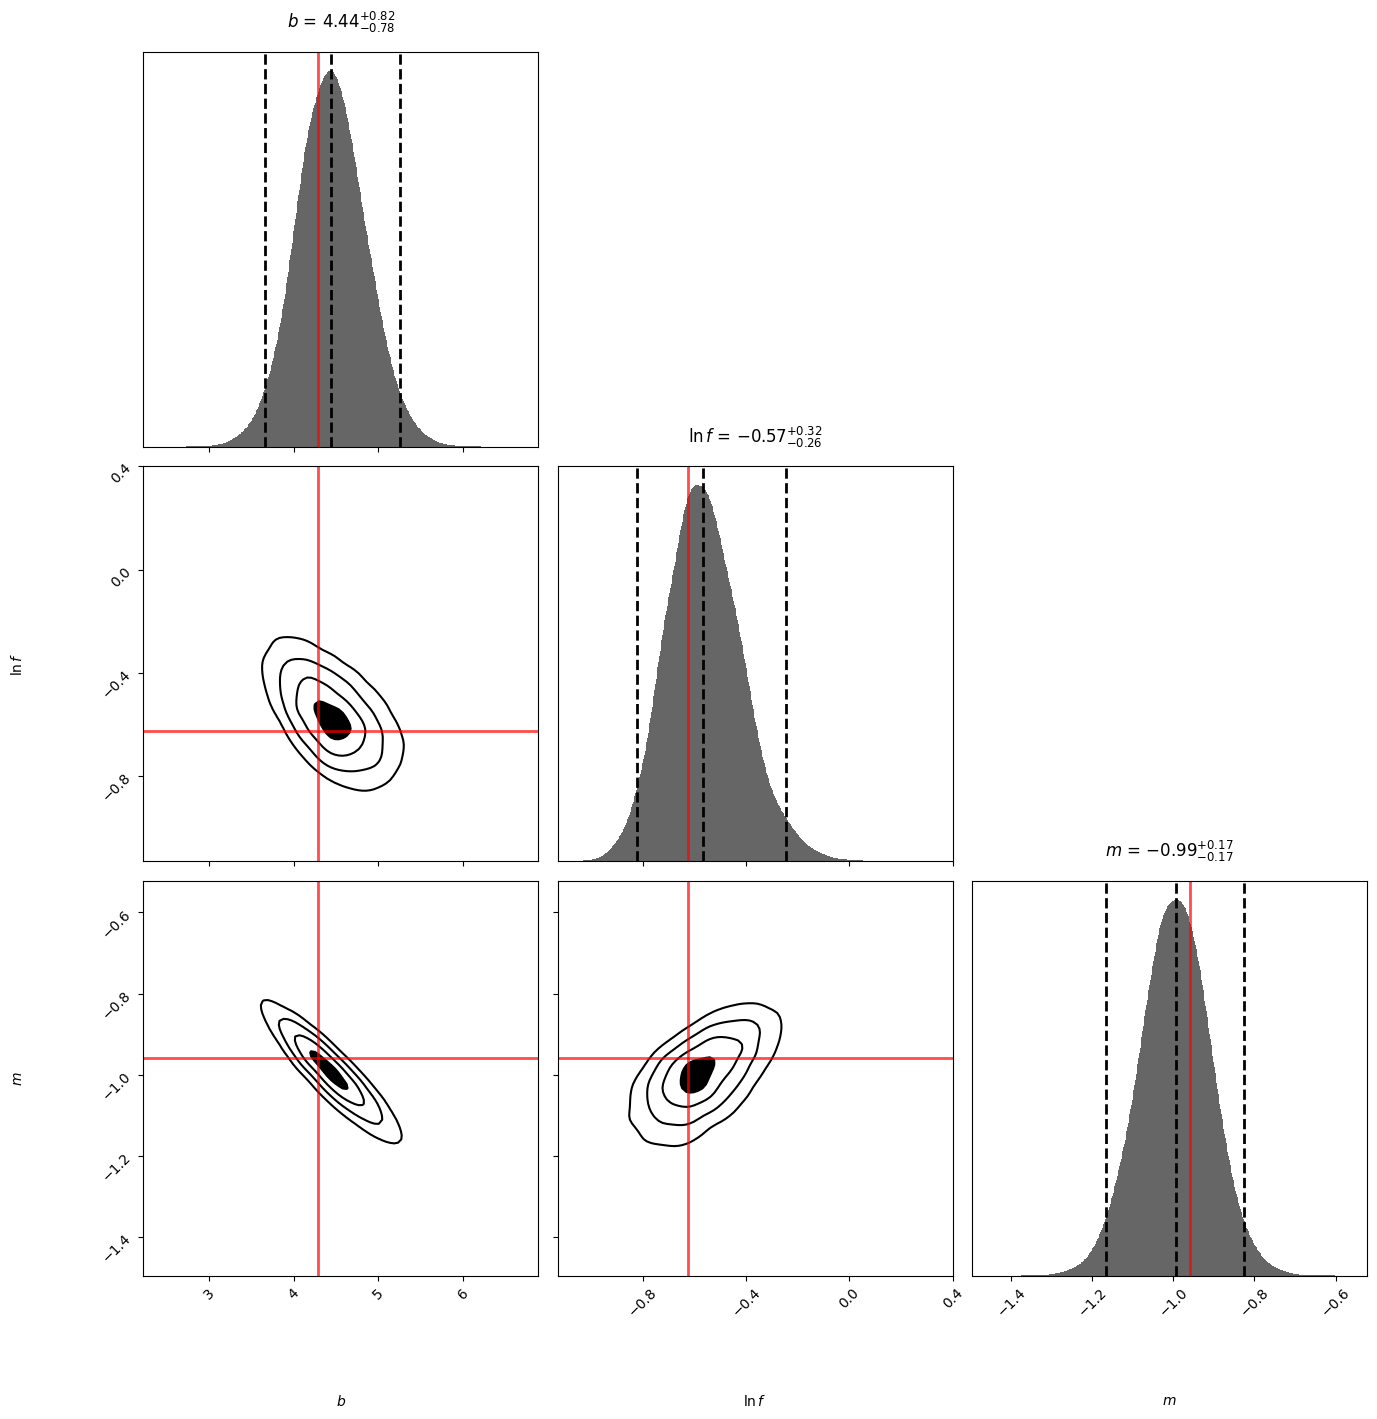

In [13]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)))

In [14]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [15]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [16]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [17]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


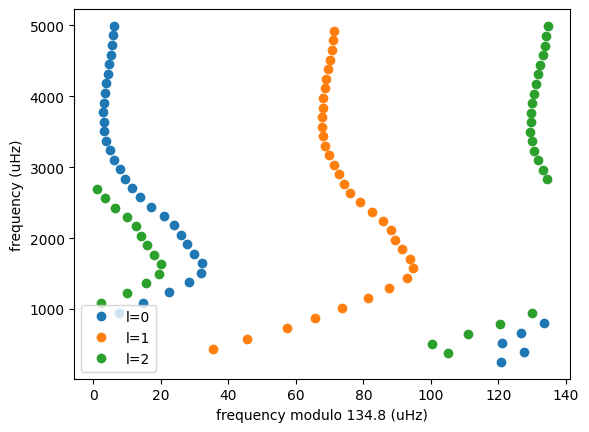

In [18]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

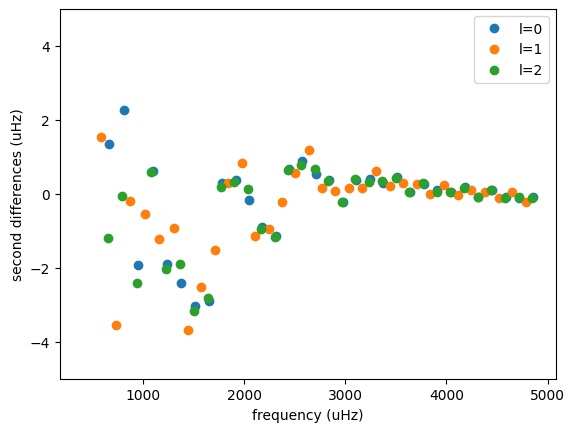

In [19]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [20]:
import tinygp
from tinygp import kernels, GaussianProcess

In [21]:
from functools import partial

In [505]:
class Distribution:
    def inv_cdf(self, u):
        pass
    
    def cdf(self, x):
        pass

    def log_probability(self, y):
        pass
    
    def sample(self, key, shape=()):
        pass
    
    @property
    def mean(self):
        pass

class Normal(Distribution):
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
    
    def inv_cdf(self, u):
        return norm.ppf(u, self.loc, self.scale)
    
    def cdf(self, x):
        return norm.cdf(x, self.loc, self.scale)

    def log_probability(self, y):
        return norm.logpdf(y, self.loc, self.scale)
    
    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.normal(key, shape=shape, dtype=dtype)

    @property
    def mean(self):
        return self.loc

    @property
    def variance(self):
        return self.scale**2


class Uniform(Distribution):
    def __init__(self, low=0.0, high=1.0):
        self.low = low
        self.high = high
        self.loc = low
        self.scale = high - low

    def inv_cdf(self, u):
        return self.loc + self.scale * u
    
    def log_probability(self, y):
        uniform.logpdf(y, self.loc, self.scale)

    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.uniform(key, shape=shape, dtype=dtype, minval=self.low, maxval=self.high)
    
    @property
    def mean(self):
        return (self.low + self.high) / 2.0
    
    @property
    def variance(self):
        return (self.high - self.low)**2 / 12.0

class CircularUniform(Uniform):
    def __init__(self):
        self.low = self.loc = 0.0
        self.high = self.scale = 2*jnp.pi

    def inv_cdf(self, u):
        return super().inv_cdf(jnp.mod(u, 1.0))
    
    def log_probability(self, y):
        uniform.logpdf(y, self.loc, self.scale)

    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.uniform(key, shape=shape, dtype=dtype, minval=self.low, maxval=self.high)
    
    @property
    def mean(self):
        return (self.low + self.high) / 2.0
    
    @property
    def variance(self):
        return (self.high - self.low)**2 / 12.0

In [538]:
0.2 * 0.6

0.12

In [539]:
class Model:
    def __init__(self, n, nu, nu_err=None, prior=None):
        self.n = n
        self.nu = nu
        self.nu_err = nu_err
        
        if prior is None:
            prior = {}
        
        # Get some useful params for prior
        w = None if nu_err is None else 1/nu_err
        popt, pcov = jnp.polyfit(self.n.astype(float), self.nu, 1, w=w, cov=True)
        perr = jnp.sqrt(jnp.diag(pcov))
            
        delta_nu = prior.setdefault(
            "delta_nu", Normal(popt[0], perr[0])
        )
        
        epsilon = prior.setdefault(
            "epsilon", Normal(popt[1]/delta_nu.mean, perr[1]/delta_nu.mean)
        )

        log_tau_he = prior.setdefault("log_tau_he", Normal(
            jnp.log(0.2/2/delta_nu.mean),  # tau ~ 0.2 tau0
            jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
        ))
        
        log_beta_he = prior.setdefault("log_beta_he", Normal(
            2*(log_tau_he.mean + jnp.log(0.1*jnp.pi)) + jnp.log(8.0),  # beta ~ 8 * (np.pi * 0.1 * tau)**2
            jnp.sqrt(0.25 + 4*log_tau_he.variance)  # 0.5
        ))
        # beta = 8 * pi**2 * delta**2
        
        prior.setdefault("log_gamma_he", Normal(
            0.5*(log_beta_he.mean -  jnp.log(jnp.pi)) + jnp.log(0.5*0.1), # gamma ~ 1/2 * 0.1 * sqrt(beta/pi)
            jnp.sqrt(0.64 + 0.25*log_beta_he.variance)  # 0.8
        ))
        # alpha_he = (dgamma / gamma)_min = gamma_he / sqrt(2pi) / delta_he
        # a_he = delta_nu * gamma_he
        
        prior.setdefault("log_alpha_cz", Normal(
            jnp.log(delta_nu.mean*30.0), 
            jnp.sqrt(0.64 + delta_nu.variance/delta_nu.mean**2)  # 0.8
        ))
        
        log_tau_cz = prior.setdefault("log_tau_cz", Normal(
            jnp.log(0.6/2/delta_nu.mean),  # tau ~ 0.6 tau0
            jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
        ))
        
        prior.setdefault("phi_he", CircularUniform())
        prior.setdefault("phi_cz", CircularUniform())
                
        prior.setdefault("log_sigma", Normal(jnp.log(1e-3), 1.0))
        prior.setdefault("log_amp", Normal(jnp.log(delta_nu.mean/2), 1.0))
        prior.setdefault("log_scale", Normal(jnp.log(5.0), 1.0))

        self.prior = prior
    
    @staticmethod
    def _oscillation(nu, tau, phi):
        return jnp.sin(4 * jnp.pi * tau * nu + phi)
    
    def smooth_component(self, params, n):
        return params["delta_nu"] * (n + params["epsilon"])
    
    def helium_amp(self, params, nu):
        return params["delta_nu"] * jnp.exp(params["log_gamma_he"]) * nu \
            * jnp.exp(- jnp.exp(params["log_beta_he"]) * nu**2)

    def helium_osc(self, params, nu):
        return self._oscillation(nu, jnp.exp(params["log_tau_he"]), params["phi_he"])

    def helium_glitch(self, params, nu):
        return self.helium_amp(params, nu) * self.helium_osc(params, nu)

    def bcz_amp(self, params, nu):
        return params["delta_nu"] * jnp.exp(params["log_alpha_cz"]) / nu**2

    def bcz_osc(self, params, nu):
        return self._oscillation(nu, jnp.exp(params["log_tau_cz"]), params["phi_cz"])

    def bcz_glitch(self, params, nu):
        return self.bcz_amp(params, nu) * self.bcz_osc(params, nu)

    def glitch(self, params, nu):
        return self.helium_glitch(params, nu) + self.bcz_glitch(params, nu)

    def build_gp(self, params):
#         kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
        kernel = 0.5*params["delta_nu"] * kernels.ExpSquared(5.0)
        
        def mean(n):
            nu_sm = self.smooth_component(params, n)
            dnu = self.glitch(params, nu_sm)
            return nu_sm + dnu
        
        diag = jnp.exp(2*params["log_sigma"])
        if self.nu_err is not None:
            diag += self.nu_err**2
        
        return GaussianProcess(kernel, self.n, mean=mean, diag=diag)

    def predict(self, params, n, **kwargs):
        gp = self.build_gp(params)
        _, cond = gp.condition(self.nu, n, **kwargs)
        return cond.loc, cond.variance

    @partial(jax.jit, static_argnums=0)
    def log_likelihood(self, params):
        gp = self.build_gp(params)
        return gp.log_probability(self.nu)
    
    @partial(jax.jit, static_argnums=0)
    def prior_transform(self, uparams):
        params = {}
        for key, value in self.prior.items():
            params[key] = value.inv_cdf(uparams[key])

#             try:
#                 params[key] = value.inv_cdf(uparams[key])
#             except jax.errors.TracerArrayConversionError as err:
#                 print(key, uparams[key])
#                 print(err)
        return params

    @partial(jax.jit, static_argnums=0)
    def log_prior(self, params):
        log_p = 0.0
        for key, value in self.prior.items():
            log_p += value.log_probability(params[key])
        return log_p

In [540]:
l = 0
n = np.arange(11, 29)
nu = data.freq.real.sel(l=l, n_pg=n).values
delta_nu, alpha = np.polyfit(n, nu, 1)
epsilon = alpha/delta_nu

print(f"{delta_nu=:.2f}")

delta_nu=132.87


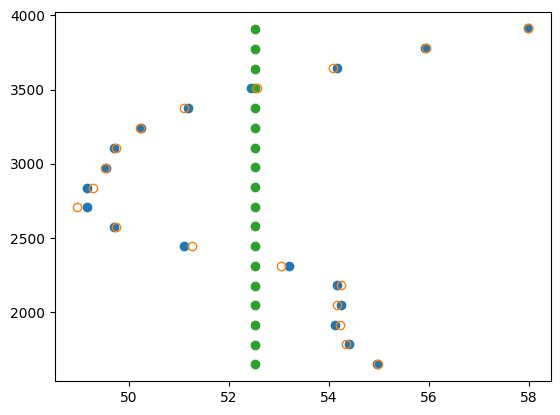

In [541]:
# init_params = {
#     "log_amp": jnp.log(10.0),
#     "log_scale": jnp.log(4.0),
#     "log_sigma": 0.0,
#     "delta_nu": delta_nu,
#     "epsilon": epsilon,
#     "log_a_he": jnp.log(1e-3),
#     "log_b_he": jnp.log(2e-7),
#     "log_tau_he": jnp.log(0.2/2/delta_nu),
#     "phi_he": 0.0,
#     "log_a_cz": jnp.log(2e6),
#     "log_tau_cz": jnp.log(0.6/2/delta_nu),
#     "phi_cz": 0.0,
# }

model = Model(n, nu)
init_params = {k: v.mean for k, v in model.prior.items()}
# init_params = {
#     "log_amp": jnp.log(10.0),
#     "log_scale": jnp.log(4.0),
#     "log_sigma": 0.0,
#     "delta_nu": delta_nu,
#     "epsilon": epsilon,
#     "log_alpha_he": jnp.log(0.08),
#     "log_beta_he": jnp.log(0.03/2/delta_nu),
#     "log_tau_he": jnp.log(0.2/2/delta_nu),
#     "phi_he": 0.0,
#     "log_alpha_cz": jnp.log(8e1) - 0.8,
#     "log_tau_cz": jnp.log(0.6/2/delta_nu),
#     "phi_cz": 0.0,
# }

nu_gp, nu_var = model.predict(init_params, n, include_mean=False)
nu_sd = np.sqrt(nu_var)

nu_sm = model.smooth_component(init_params, n)
dnu_init = model.glitch(init_params, nu_sm)

nu_init = nu_gp + nu_sm + dnu_init

plt.plot(nu%delta_nu, nu, "o")
plt.errorbar(nu_init%delta_nu, nu_init, xerr=nu_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_sm%delta_nu, nu_sm, "o")

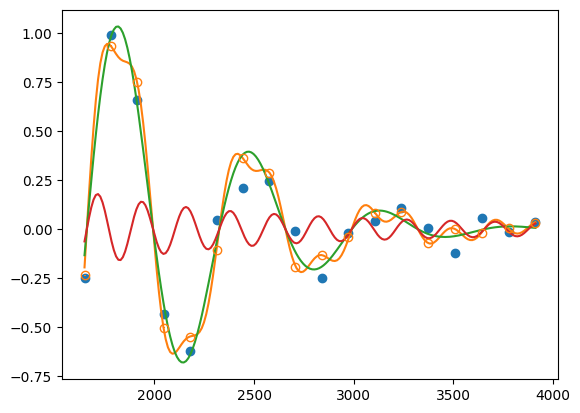

In [542]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = model.glitch(init_params, nu_pred)

plt.plot(nu, nu-nu_init+dnu_init, "o")
plt.errorbar(nu, dnu_init, yerr=nu_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_pred, dnu_pred, c="C1")

plt.plot(nu_pred, model.helium_glitch(init_params, nu_pred))
plt.plot(nu_pred, model.bcz_glitch(init_params, nu_pred))

In [543]:
leaves, treedef = tree_util.tree_flatten(init_params)
ndim = len(leaves)

In [544]:
def log_likelihood_wrapper(x):
    params = tree_util.tree_unflatten(treedef, x)
    return model.log_likelihood(params)

def prior_transform_wrapper(u):
    params = tree_util.tree_unflatten(treedef, u)
    return tree_util.tree_leaves(model.prior_transform(params))

# def gradient_wrapper(u):
#     uparams = tree_util.tree_unflatten(treedef, u)
#     return np.array(tree_util.tree_leaves(gradient(uparams)))

In [546]:
sampler = dynesty.NestedSampler(log_likelihood_wrapper, prior_transform_wrapper, ndim, periodic=[10, 11])
sampler.run_nested()

14289it [02:05, 114.25it/s, +500 | bound: 171 | nc: 1 | ncall: 417719 | eff(%):  3.545 | loglstar:   -inf < 12.336 <    inf | logz: -15.708 +/-  0.238 | dlogz:  0.001 >  0.509] 


In [547]:
res = sampler.results

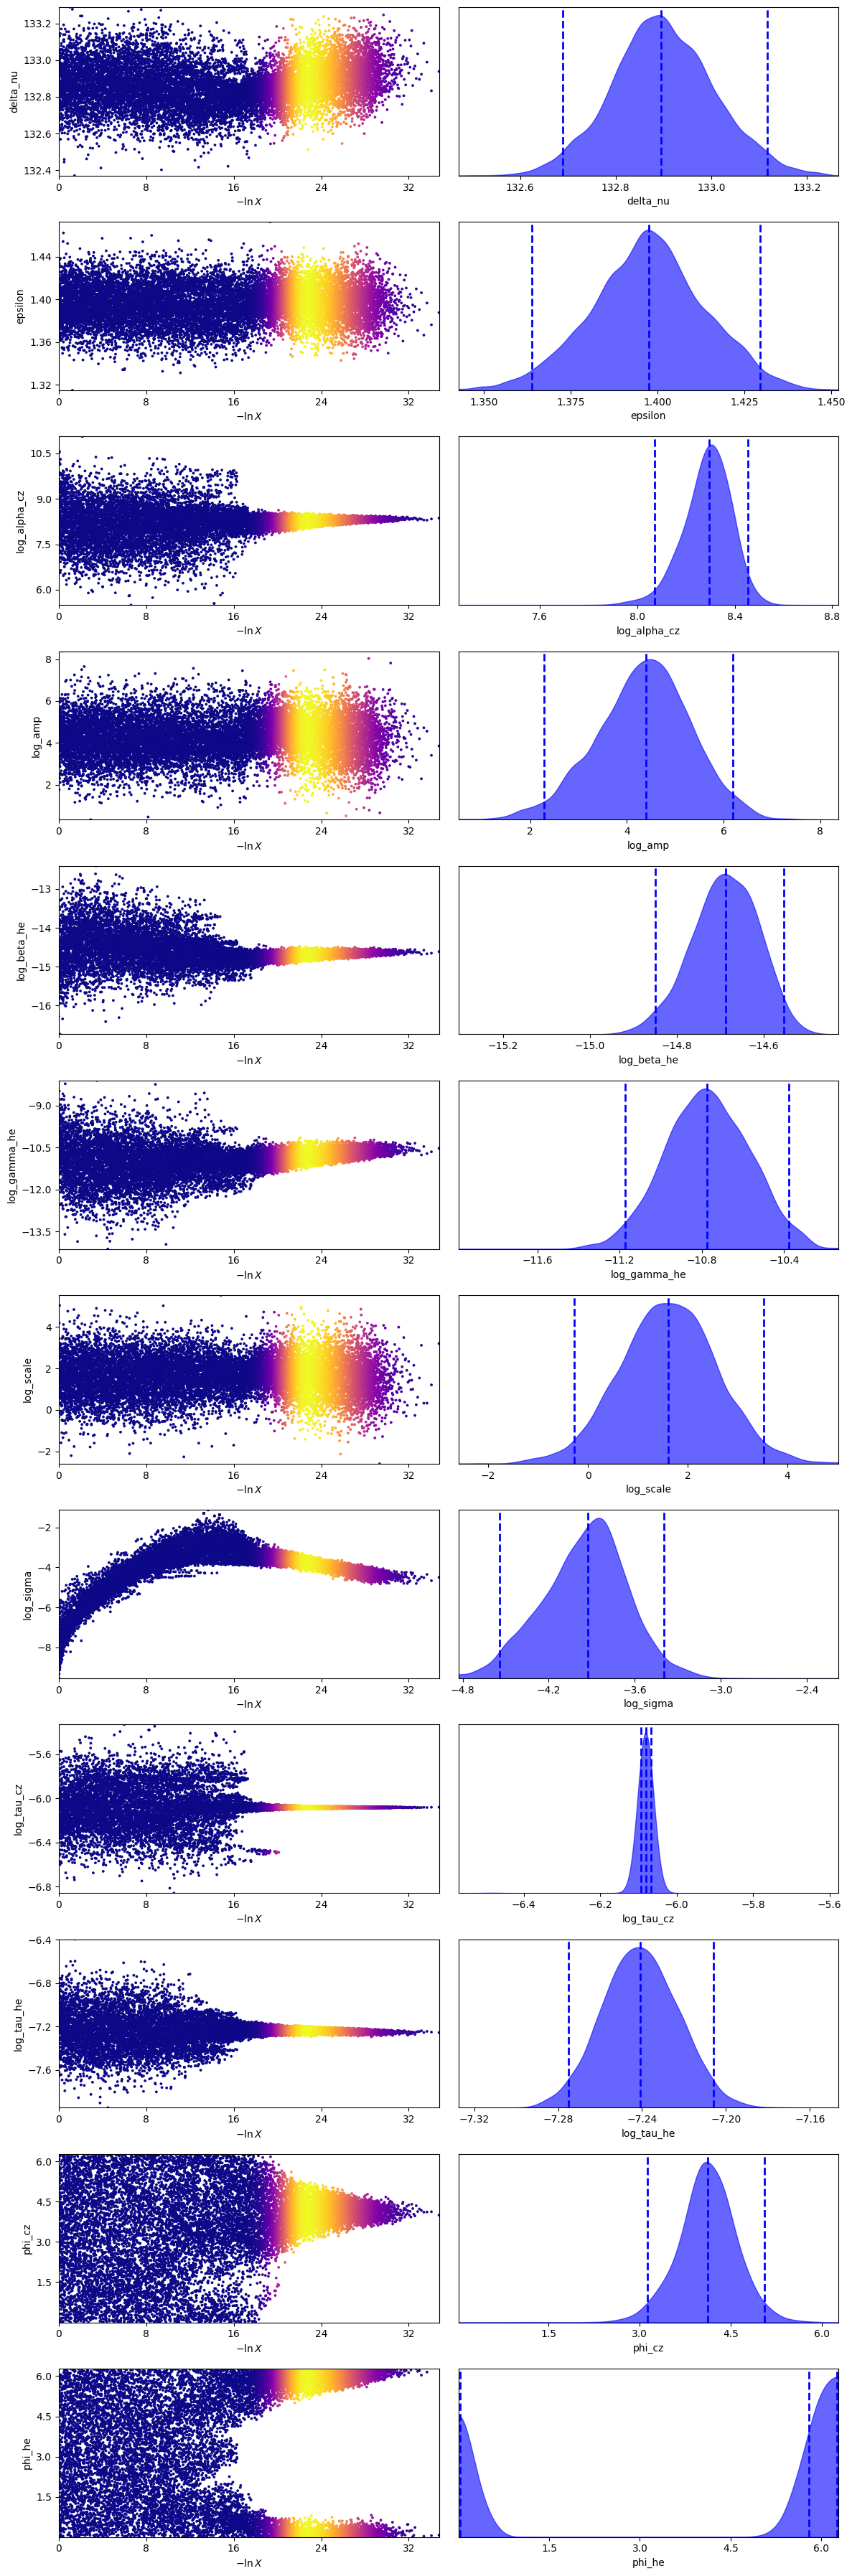

In [548]:
labels = tree_util.tree_leaves({k: k for k in init_params.keys()})
# truths = tree_util.tree_leaves(true_params)
fig, axes = dyplot.traceplot(res, labels=labels)  #, fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

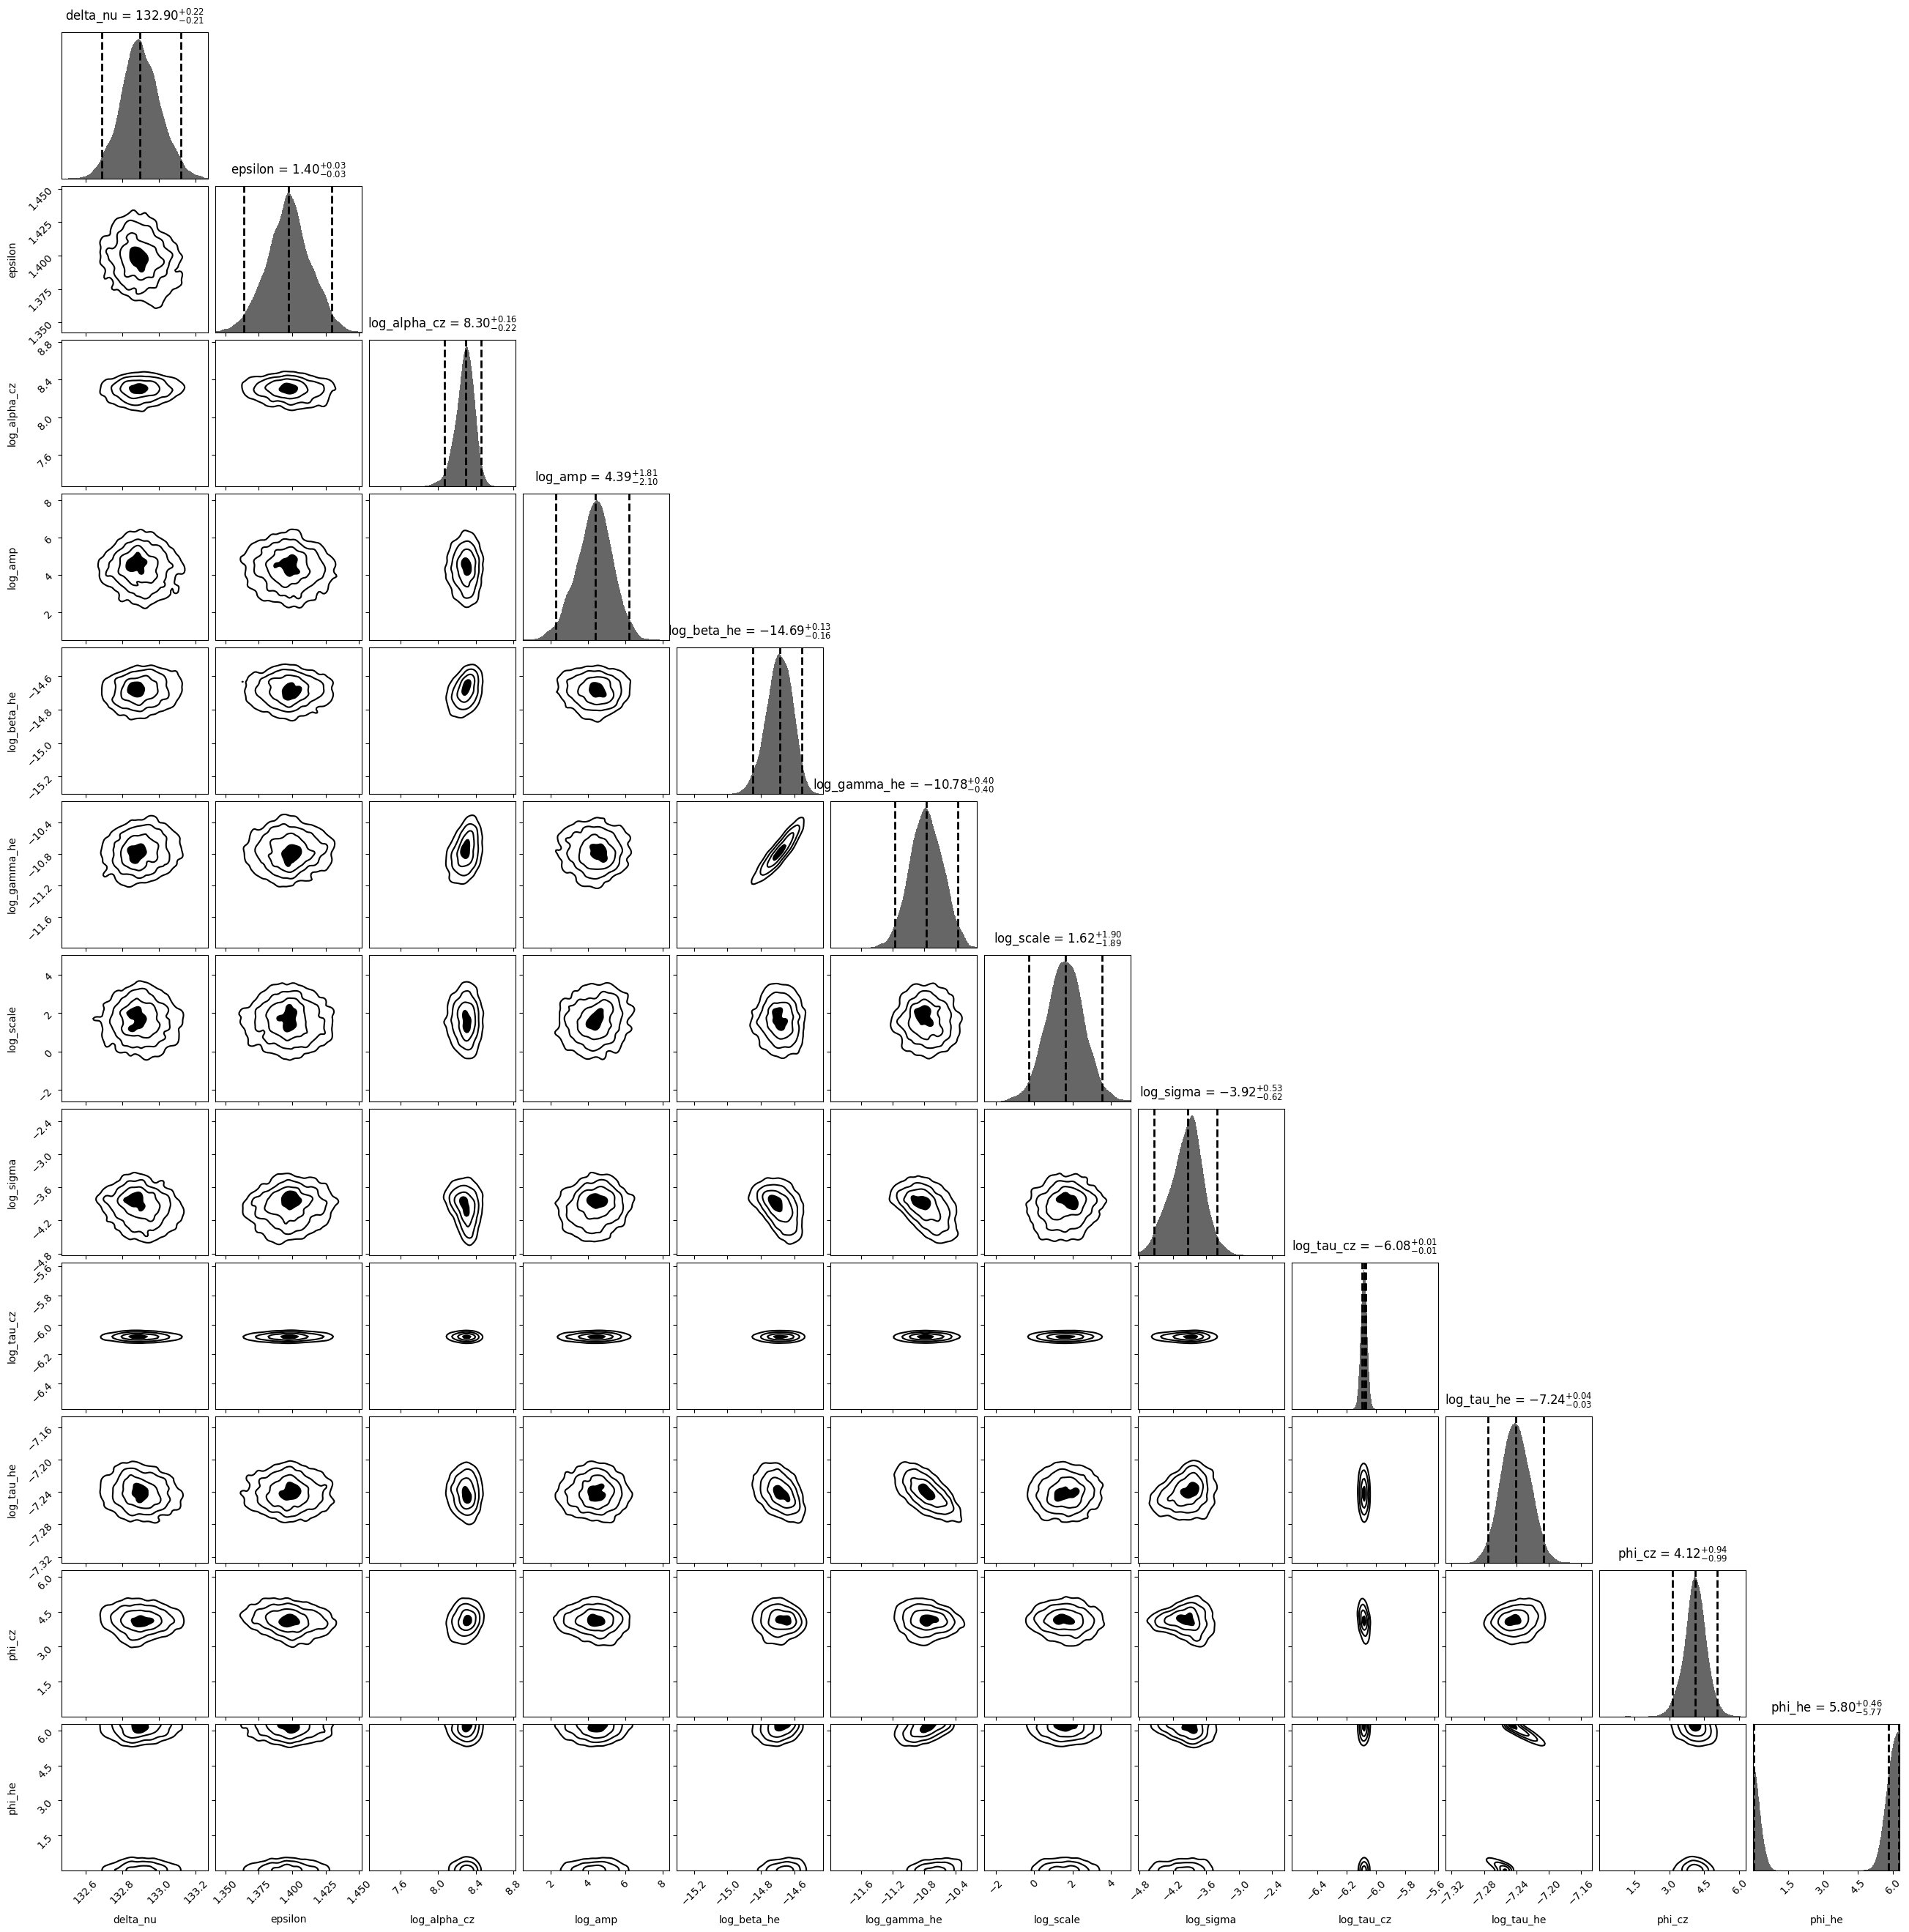

In [549]:
fig, axes = dyplot.cornerplot(res, show_titles=True, title_kwargs={'y': 1.04}, labels=labels)

In [550]:
samples_flat, weights = res.samples, res.importance_weights()
samples_equal = dynesty.utils.resample_equal(samples_flat, weights)
samples = tree_util.tree_unflatten(treedef, list(samples_equal.T))

In [551]:
np.exp(samples["log_tau_he"]).mean()

0.000716839038177115

In [552]:
np.median(np.exp(samples["log_tau_cz"]))

0.0022862395909229736

In [553]:
dnu = jax.vmap(model.glitch, in_axes=(0, None))(samples, nu_pred)
dnu_med = np.median(dnu, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu, [.16, .84], axis=0)

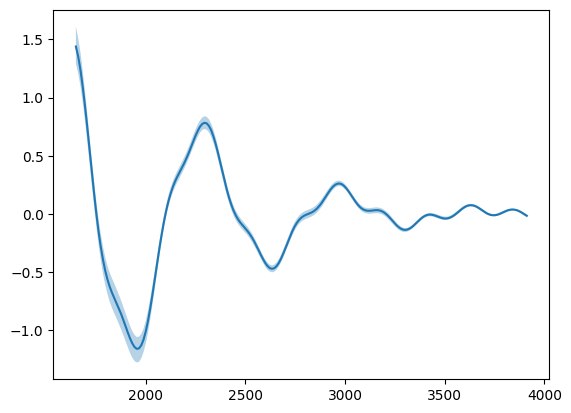

In [554]:
plt.plot(nu_pred, dnu_med)
plt.fill_between(nu_pred, dnu_lower, dnu_upper, alpha=0.33)

(-2.0, 2.0)

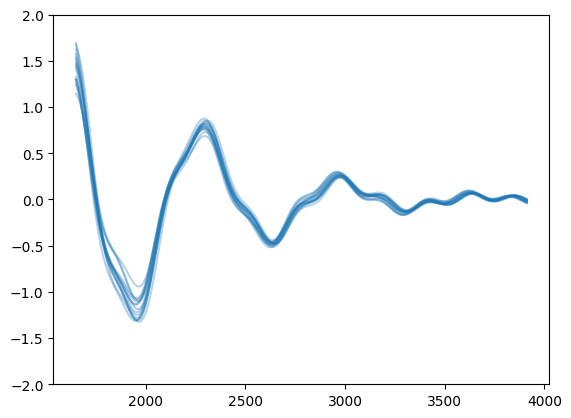

In [555]:
thin = 1000
y = dnu[::thin]
x = np.broadcast_to(nu_pred, y.shape)
plt.plot(x.T, y.T, color="C0", alpha=0.33);
plt.ylim(-2, 2)